# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

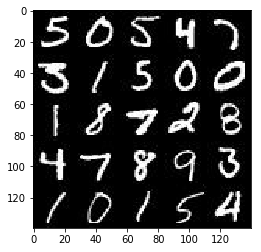

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

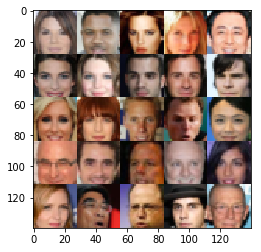

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.06, keep_prob=0.6):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02))
        # x1 = tf.nn.dropout(x1, keep_prob)
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02))
        # x2 = tf.nn.dropout(x2, keep_prob)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02))
        # x3 = tf.nn.dropout(x3, keep_prob)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=keep_prob)
        out = tf.sigmoid(logits)
        # Adding dropout in the dense layer and commenting it out in the conv2d layers appeared to slightly improve results.

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.18, keep_prob=0.6):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        #print("x1 shape =",x1.get_shape().as_list())
        # Now 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.nn.dropout(x2, keep_prob/4+3/4)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #print("x2 shape =",x2.get_shape().as_list())
        # Now 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, (keep_prob+1)/2)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        #print("x3 shape =",x3.get_shape().as_list())
        # Now 14x14x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.nn.dropout(x4, keep_prob)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4, x4)
        #print("x4 shape =",x4.get_shape().as_list())
        # Now 14x14x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
        #print("out shape =",out.get_shape().as_list())
        # Now 28x28x5
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate_ref, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    _, image_width, image_height, image_channels = data_shape
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    input_real, input_z, learning_rate_p = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_p, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images = batch_images*2
                
                learning_rate = learning_rate_ref/5 + 8*learning_rate_ref/5/(1+np.exp(steps/500))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_p: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_p: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_p: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}...".format(steps),
                          "Learning rate {:.7f}...".format(learning_rate),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    last_show_step = steps
        
        if steps>last_show_step:
            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10... Learning rate 0.0009920... Discriminator Loss: 2.5951... Generator Loss: 2.0691
Epoch 1/2... Step 20... Learning rate 0.0009840... Discriminator Loss: 2.4241... Generator Loss: 0.4399
Epoch 1/2... Step 30... Learning rate 0.0009760... Discriminator Loss: 2.2431... Generator Loss: 0.4531
Epoch 1/2... Step 40... Learning rate 0.0009680... Discriminator Loss: 2.2731... Generator Loss: 0.6423
Epoch 1/2... Step 50... Learning rate 0.0009600... Discriminator Loss: 1.7854... Generator Loss: 0.4201
Epoch 1/2... Step 60... Learning rate 0.0009521... Discriminator Loss: 1.8310... Generator Loss: 0.3969
Epoch 1/2... Step 70... Learning rate 0.0009441... Discriminator Loss: 1.8808... Generator Loss: 0.7894
Epoch 1/2... Step 80... Learning rate 0.0009361... Discriminator Loss: 1.5788... Generator Loss: 0.7928
Epoch 1/2... Step 90... Learning rate 0.0009282... Discriminator Loss: 1.8612... Generator Loss: 0.3739
Epoch 1/2... Step 100... Learning rate 0.0009203... Discriminato

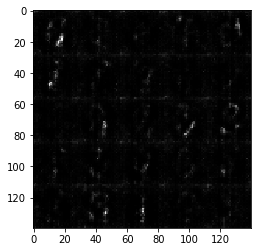

Epoch 1/2... Step 110... Learning rate 0.0009124... Discriminator Loss: 1.7858... Generator Loss: 0.3557
Epoch 1/2... Step 120... Learning rate 0.0009045... Discriminator Loss: 1.7554... Generator Loss: 0.7128
Epoch 1/2... Step 130... Learning rate 0.0008966... Discriminator Loss: 1.8134... Generator Loss: 0.3034
Epoch 1/2... Step 140... Learning rate 0.0008887... Discriminator Loss: 1.6280... Generator Loss: 0.4572
Epoch 1/2... Step 150... Learning rate 0.0008809... Discriminator Loss: 1.5760... Generator Loss: 0.5094
Epoch 1/2... Step 160... Learning rate 0.0008731... Discriminator Loss: 1.3880... Generator Loss: 1.0557
Epoch 1/2... Step 170... Learning rate 0.0008653... Discriminator Loss: 1.4770... Generator Loss: 0.5356
Epoch 1/2... Step 180... Learning rate 0.0008575... Discriminator Loss: 1.5225... Generator Loss: 0.8168
Epoch 1/2... Step 190... Learning rate 0.0008498... Discriminator Loss: 1.5815... Generator Loss: 0.5346
Epoch 1/2... Step 200... Learning rate 0.0008421... Dis

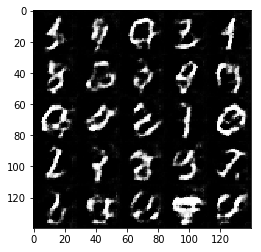

Epoch 1/2... Step 210... Learning rate 0.0008344... Discriminator Loss: 1.6239... Generator Loss: 0.5581
Epoch 1/2... Step 220... Learning rate 0.0008268... Discriminator Loss: 1.6253... Generator Loss: 1.0502
Epoch 1/2... Step 230... Learning rate 0.0008192... Discriminator Loss: 1.5133... Generator Loss: 0.4714
Epoch 1/2... Step 240... Learning rate 0.0008116... Discriminator Loss: 1.4173... Generator Loss: 0.8726
Epoch 1/2... Step 250... Learning rate 0.0008041... Discriminator Loss: 1.6197... Generator Loss: 0.3942
Epoch 1/2... Step 260... Learning rate 0.0007966... Discriminator Loss: 1.2560... Generator Loss: 0.9683
Epoch 1/2... Step 270... Learning rate 0.0007891... Discriminator Loss: 1.4531... Generator Loss: 0.8317
Epoch 1/2... Step 280... Learning rate 0.0007817... Discriminator Loss: 1.4159... Generator Loss: 0.5700
Epoch 1/2... Step 290... Learning rate 0.0007743... Discriminator Loss: 1.1968... Generator Loss: 0.7556
Epoch 1/2... Step 300... Learning rate 0.0007669... Dis

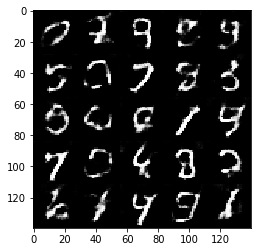

Epoch 1/2... Step 310... Learning rate 0.0007597... Discriminator Loss: 1.4596... Generator Loss: 0.6262
Epoch 1/2... Step 320... Learning rate 0.0007524... Discriminator Loss: 1.4230... Generator Loss: 0.6654
Epoch 1/2... Step 330... Learning rate 0.0007452... Discriminator Loss: 1.5115... Generator Loss: 0.6332
Epoch 1/2... Step 340... Learning rate 0.0007380... Discriminator Loss: 1.4759... Generator Loss: 0.6312
Epoch 1/2... Step 350... Learning rate 0.0007309... Discriminator Loss: 1.3459... Generator Loss: 0.9043
Epoch 1/2... Step 360... Learning rate 0.0007238... Discriminator Loss: 1.3480... Generator Loss: 0.6565
Epoch 1/2... Step 370... Learning rate 0.0007168... Discriminator Loss: 1.6537... Generator Loss: 0.3655
Epoch 1/2... Step 380... Learning rate 0.0007098... Discriminator Loss: 1.3600... Generator Loss: 0.6814
Epoch 1/2... Step 390... Learning rate 0.0007029... Discriminator Loss: 1.2964... Generator Loss: 1.0274
Epoch 1/2... Step 400... Learning rate 0.0006960... Dis

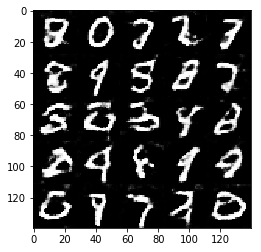

Epoch 1/2... Step 410... Learning rate 0.0006892... Discriminator Loss: 1.2734... Generator Loss: 0.7919
Epoch 1/2... Step 420... Learning rate 0.0006825... Discriminator Loss: 1.3504... Generator Loss: 0.6296
Epoch 1/2... Step 430... Learning rate 0.0006757... Discriminator Loss: 1.4578... Generator Loss: 0.5734
Epoch 1/2... Step 440... Learning rate 0.0006691... Discriminator Loss: 1.2085... Generator Loss: 0.9098
Epoch 1/2... Step 450... Learning rate 0.0006625... Discriminator Loss: 1.6847... Generator Loss: 0.3606
Epoch 1/2... Step 460... Learning rate 0.0006559... Discriminator Loss: 1.5001... Generator Loss: 0.4208
Epoch 1/2... Step 470... Learning rate 0.0006494... Discriminator Loss: 1.2472... Generator Loss: 1.0483
Epoch 1/2... Step 480... Learning rate 0.0006430... Discriminator Loss: 1.3282... Generator Loss: 1.4103
Epoch 1/2... Step 490... Learning rate 0.0006366... Discriminator Loss: 1.2607... Generator Loss: 0.6489
Epoch 1/2... Step 500... Learning rate 0.0006303... Dis

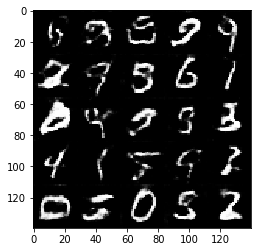

Epoch 1/2... Step 510... Learning rate 0.0006240... Discriminator Loss: 1.3275... Generator Loss: 0.5362
Epoch 1/2... Step 520... Learning rate 0.0006178... Discriminator Loss: 1.6574... Generator Loss: 0.3520
Epoch 1/2... Step 530... Learning rate 0.0006117... Discriminator Loss: 1.5197... Generator Loss: 0.4031
Epoch 1/2... Step 540... Learning rate 0.0006056... Discriminator Loss: 1.4000... Generator Loss: 0.5548
Epoch 1/2... Step 550... Learning rate 0.0005996... Discriminator Loss: 1.2988... Generator Loss: 0.6695
Epoch 1/2... Step 560... Learning rate 0.0005936... Discriminator Loss: 1.5539... Generator Loss: 1.4684
Epoch 1/2... Step 570... Learning rate 0.0005877... Discriminator Loss: 1.3140... Generator Loss: 0.5739
Epoch 1/2... Step 580... Learning rate 0.0005819... Discriminator Loss: 1.1856... Generator Loss: 1.0059
Epoch 1/2... Step 590... Learning rate 0.0005761... Discriminator Loss: 1.2170... Generator Loss: 1.5745
Epoch 1/2... Step 600... Learning rate 0.0005704... Dis

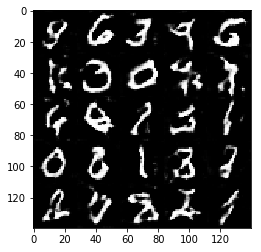

Epoch 1/2... Step 610... Learning rate 0.0005647... Discriminator Loss: 1.2590... Generator Loss: 0.6668
Epoch 1/2... Step 620... Learning rate 0.0005591... Discriminator Loss: 1.9070... Generator Loss: 0.2923
Epoch 1/2... Step 630... Learning rate 0.0005536... Discriminator Loss: 1.1737... Generator Loss: 0.6957
Epoch 1/2... Step 640... Learning rate 0.0005481... Discriminator Loss: 1.1288... Generator Loss: 0.8978
Epoch 1/2... Step 650... Learning rate 0.0005427... Discriminator Loss: 1.3532... Generator Loss: 1.6007
Epoch 1/2... Step 660... Learning rate 0.0005373... Discriminator Loss: 1.0622... Generator Loss: 1.0940
Epoch 1/2... Step 670... Learning rate 0.0005320... Discriminator Loss: 1.3103... Generator Loss: 0.6505
Epoch 1/2... Step 680... Learning rate 0.0005268... Discriminator Loss: 1.2925... Generator Loss: 0.6618
Epoch 1/2... Step 690... Learning rate 0.0005216... Discriminator Loss: 1.2104... Generator Loss: 0.6962
Epoch 1/2... Step 700... Learning rate 0.0005165... Dis

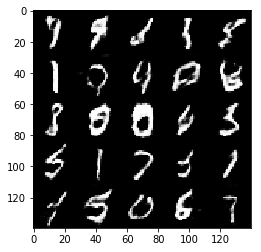

Epoch 1/2... Step 710... Learning rate 0.0005115... Discriminator Loss: 1.0954... Generator Loss: 0.7954
Epoch 1/2... Step 720... Learning rate 0.0005065... Discriminator Loss: 1.3348... Generator Loss: 0.5487
Epoch 1/2... Step 730... Learning rate 0.0005015... Discriminator Loss: 1.1748... Generator Loss: 0.7468
Epoch 1/2... Step 740... Learning rate 0.0004967... Discriminator Loss: 1.0659... Generator Loss: 1.2207
Epoch 1/2... Step 750... Learning rate 0.0004919... Discriminator Loss: 1.0707... Generator Loss: 1.0173
Epoch 1/2... Step 760... Learning rate 0.0004871... Discriminator Loss: 1.3190... Generator Loss: 0.5991
Epoch 1/2... Step 770... Learning rate 0.0004825... Discriminator Loss: 1.0283... Generator Loss: 1.2956
Epoch 1/2... Step 780... Learning rate 0.0004778... Discriminator Loss: 1.4885... Generator Loss: 0.4957
Epoch 1/2... Step 790... Learning rate 0.0004733... Discriminator Loss: 1.1141... Generator Loss: 0.8907
Epoch 1/2... Step 800... Learning rate 0.0004688... Dis

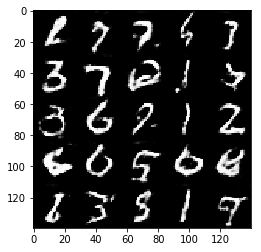

Epoch 1/2... Step 810... Learning rate 0.0004643... Discriminator Loss: 1.3033... Generator Loss: 0.7390
Epoch 1/2... Step 820... Learning rate 0.0004599... Discriminator Loss: 1.0821... Generator Loss: 1.1590
Epoch 1/2... Step 830... Learning rate 0.0004556... Discriminator Loss: 0.8968... Generator Loss: 1.3477
Epoch 1/2... Step 840... Learning rate 0.0004514... Discriminator Loss: 1.2837... Generator Loss: 0.6003
Epoch 1/2... Step 850... Learning rate 0.0004471... Discriminator Loss: 1.0657... Generator Loss: 0.8786
Epoch 1/2... Step 860... Learning rate 0.0004430... Discriminator Loss: 1.3138... Generator Loss: 0.5051
Epoch 1/2... Step 870... Learning rate 0.0004389... Discriminator Loss: 0.9377... Generator Loss: 1.0157
Epoch 1/2... Step 880... Learning rate 0.0004349... Discriminator Loss: 1.1743... Generator Loss: 1.3997
Epoch 1/2... Step 890... Learning rate 0.0004309... Discriminator Loss: 1.2483... Generator Loss: 0.6183
Epoch 1/2... Step 900... Learning rate 0.0004270... Dis

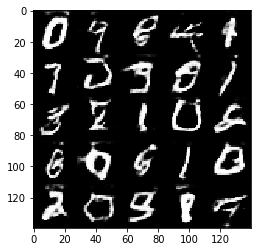

Epoch 1/2... Step 910... Learning rate 0.0004231... Discriminator Loss: 1.0873... Generator Loss: 0.9628
Epoch 1/2... Step 920... Learning rate 0.0004193... Discriminator Loss: 1.1781... Generator Loss: 0.7533
Epoch 1/2... Step 930... Learning rate 0.0004155... Discriminator Loss: 1.2784... Generator Loss: 0.5930
Epoch 1/2... Step 940... Learning rate 0.0004118... Discriminator Loss: 1.2229... Generator Loss: 0.6162
Epoch 1/2... Step 950... Learning rate 0.0004082... Discriminator Loss: 1.2406... Generator Loss: 0.7631
Epoch 1/2... Step 960... Learning rate 0.0004046... Discriminator Loss: 0.9086... Generator Loss: 1.4318
Epoch 1/2... Step 970... Learning rate 0.0004010... Discriminator Loss: 0.8968... Generator Loss: 1.1432
Epoch 1/2... Step 980... Learning rate 0.0003975... Discriminator Loss: 0.7992... Generator Loss: 1.3217
Epoch 1/2... Step 990... Learning rate 0.0003941... Discriminator Loss: 1.0119... Generator Loss: 1.1937
Epoch 1/2... Step 1000... Learning rate 0.0003907... Di

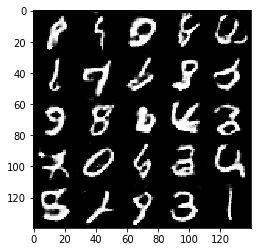

Epoch 1/2... Step 1010... Learning rate 0.0003874... Discriminator Loss: 1.0644... Generator Loss: 0.9786
Epoch 1/2... Step 1020... Learning rate 0.0003841... Discriminator Loss: 1.1542... Generator Loss: 0.7206
Epoch 1/2... Step 1030... Learning rate 0.0003809... Discriminator Loss: 1.0753... Generator Loss: 0.8404
Epoch 1/2... Step 1040... Learning rate 0.0003777... Discriminator Loss: 0.9887... Generator Loss: 0.9522
Epoch 1/2... Step 1050... Learning rate 0.0003746... Discriminator Loss: 1.0634... Generator Loss: 0.7697
Epoch 1/2... Step 1060... Learning rate 0.0003715... Discriminator Loss: 0.9952... Generator Loss: 1.8738
Epoch 1/2... Step 1070... Learning rate 0.0003684... Discriminator Loss: 0.7380... Generator Loss: 1.4602
Epoch 1/2... Step 1080... Learning rate 0.0003654... Discriminator Loss: 1.4346... Generator Loss: 0.4114
Epoch 1/2... Step 1090... Learning rate 0.0003625... Discriminator Loss: 0.8929... Generator Loss: 1.1861
Epoch 1/2... Step 1100... Learning rate 0.0003

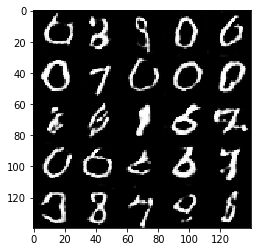

Epoch 1/2... Step 1110... Learning rate 0.0003568... Discriminator Loss: 0.7512... Generator Loss: 1.6559
Epoch 1/2... Step 1120... Learning rate 0.0003539... Discriminator Loss: 1.1335... Generator Loss: 0.8620
Epoch 1/2... Step 1130... Learning rate 0.0003512... Discriminator Loss: 0.7049... Generator Loss: 1.5390
Epoch 1/2... Step 1140... Learning rate 0.0003485... Discriminator Loss: 0.9880... Generator Loss: 0.8055
Epoch 1/2... Step 1150... Learning rate 0.0003458... Discriminator Loss: 0.8899... Generator Loss: 1.9228
Epoch 1/2... Step 1160... Learning rate 0.0003432... Discriminator Loss: 0.8973... Generator Loss: 0.9716
Epoch 1/2... Step 1170... Learning rate 0.0003406... Discriminator Loss: 1.4453... Generator Loss: 0.6265
Epoch 1/2... Step 1180... Learning rate 0.0003380... Discriminator Loss: 1.6430... Generator Loss: 0.4351
Epoch 1/2... Step 1190... Learning rate 0.0003355... Discriminator Loss: 0.6965... Generator Loss: 1.5075
Epoch 1/2... Step 1200... Learning rate 0.0003

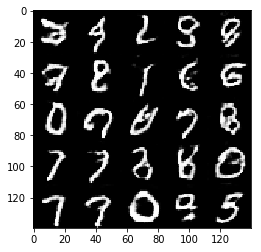

Epoch 1/2... Step 1210... Learning rate 0.0003307... Discriminator Loss: 1.1949... Generator Loss: 0.8523
Epoch 1/2... Step 1220... Learning rate 0.0003283... Discriminator Loss: 1.2289... Generator Loss: 0.7362
Epoch 1/2... Step 1230... Learning rate 0.0003259... Discriminator Loss: 1.1085... Generator Loss: 0.8862
Epoch 1/2... Step 1240... Learning rate 0.0003236... Discriminator Loss: 1.2995... Generator Loss: 0.5355
Epoch 1/2... Step 1250... Learning rate 0.0003214... Discriminator Loss: 1.3522... Generator Loss: 0.7168
Epoch 1/2... Step 1260... Learning rate 0.0003191... Discriminator Loss: 1.1487... Generator Loss: 0.7235
Epoch 1/2... Step 1270... Learning rate 0.0003170... Discriminator Loss: 0.6692... Generator Loss: 1.9729
Epoch 1/2... Step 1280... Learning rate 0.0003148... Discriminator Loss: 0.7909... Generator Loss: 1.9733
Epoch 1/2... Step 1290... Learning rate 0.0003127... Discriminator Loss: 0.7503... Generator Loss: 1.3873
Epoch 1/2... Step 1300... Learning rate 0.0003

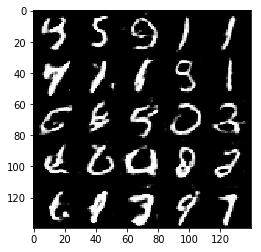

Epoch 1/2... Step 1310... Learning rate 0.0003086... Discriminator Loss: 0.8463... Generator Loss: 1.2907
Epoch 1/2... Step 1320... Learning rate 0.0003066... Discriminator Loss: 1.2250... Generator Loss: 2.0401
Epoch 1/2... Step 1330... Learning rate 0.0003046... Discriminator Loss: 0.6798... Generator Loss: 1.4631
Epoch 1/2... Step 1340... Learning rate 0.0003027... Discriminator Loss: 0.8193... Generator Loss: 1.4338
Epoch 1/2... Step 1350... Learning rate 0.0003008... Discriminator Loss: 1.2740... Generator Loss: 0.5557
Epoch 1/2... Step 1360... Learning rate 0.0002989... Discriminator Loss: 0.8265... Generator Loss: 1.0380
Epoch 1/2... Step 1370... Learning rate 0.0002970... Discriminator Loss: 0.6988... Generator Loss: 1.7480
Epoch 1/2... Step 1380... Learning rate 0.0002952... Discriminator Loss: 0.8449... Generator Loss: 0.7713
Epoch 1/2... Step 1390... Learning rate 0.0002935... Discriminator Loss: 0.9519... Generator Loss: 0.8498
Epoch 1/2... Step 1400... Learning rate 0.0002

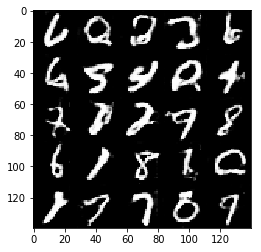

Epoch 1/2... Step 1410... Learning rate 0.0002900... Discriminator Loss: 1.0699... Generator Loss: 0.9113
Epoch 1/2... Step 1420... Learning rate 0.0002883... Discriminator Loss: 0.6705... Generator Loss: 1.5447
Epoch 1/2... Step 1430... Learning rate 0.0002867... Discriminator Loss: 1.0471... Generator Loss: 0.9102
Epoch 1/2... Step 1440... Learning rate 0.0002850... Discriminator Loss: 0.7553... Generator Loss: 2.0092
Epoch 1/2... Step 1450... Learning rate 0.0002834... Discriminator Loss: 0.7594... Generator Loss: 1.6984
Epoch 1/2... Step 1460... Learning rate 0.0002819... Discriminator Loss: 0.9107... Generator Loss: 0.9515
Epoch 1/2... Step 1470... Learning rate 0.0002803... Discriminator Loss: 0.7623... Generator Loss: 2.5692
Epoch 1/2... Step 1480... Learning rate 0.0002788... Discriminator Loss: 1.0600... Generator Loss: 1.2348
Epoch 1/2... Step 1490... Learning rate 0.0002773... Discriminator Loss: 0.9569... Generator Loss: 0.8165
Epoch 1/2... Step 1500... Learning rate 0.0002

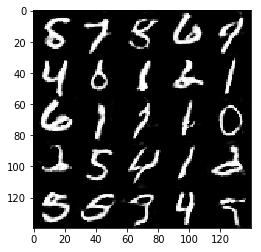

Epoch 1/2... Step 1510... Learning rate 0.0002744... Discriminator Loss: 1.0324... Generator Loss: 0.9329
Epoch 1/2... Step 1520... Learning rate 0.0002730... Discriminator Loss: 0.6989... Generator Loss: 1.3214
Epoch 1/2... Step 1530... Learning rate 0.0002717... Discriminator Loss: 0.7055... Generator Loss: 1.3275
Epoch 1/2... Step 1540... Learning rate 0.0002703... Discriminator Loss: 0.7869... Generator Loss: 1.5495
Epoch 1/2... Step 1550... Learning rate 0.0002690... Discriminator Loss: 0.6207... Generator Loss: 1.6698
Epoch 1/2... Step 1560... Learning rate 0.0002677... Discriminator Loss: 0.8380... Generator Loss: 1.3478
Epoch 1/2... Step 1570... Learning rate 0.0002664... Discriminator Loss: 1.0063... Generator Loss: 0.9493
Epoch 1/2... Step 1580... Learning rate 0.0002651... Discriminator Loss: 0.6128... Generator Loss: 1.6598
Epoch 1/2... Step 1590... Learning rate 0.0002639... Discriminator Loss: 0.6467... Generator Loss: 1.5110
Epoch 1/2... Step 1600... Learning rate 0.0002

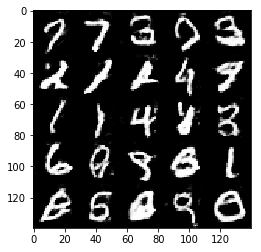

Epoch 1/2... Step 1610... Learning rate 0.0002615... Discriminator Loss: 0.8383... Generator Loss: 1.0965
Epoch 1/2... Step 1620... Learning rate 0.0002603... Discriminator Loss: 0.6474... Generator Loss: 1.8115
Epoch 1/2... Step 1630... Learning rate 0.0002592... Discriminator Loss: 1.2263... Generator Loss: 0.6619
Epoch 1/2... Step 1640... Learning rate 0.0002580... Discriminator Loss: 0.6159... Generator Loss: 1.7878
Epoch 1/2... Step 1650... Learning rate 0.0002569... Discriminator Loss: 0.8487... Generator Loss: 1.1847
Epoch 1/2... Step 1660... Learning rate 0.0002558... Discriminator Loss: 0.5932... Generator Loss: 2.0625
Epoch 1/2... Step 1670... Learning rate 0.0002548... Discriminator Loss: 0.8212... Generator Loss: 1.2514
Epoch 1/2... Step 1680... Learning rate 0.0002537... Discriminator Loss: 0.5975... Generator Loss: 2.1609
Epoch 1/2... Step 1690... Learning rate 0.0002527... Discriminator Loss: 0.5128... Generator Loss: 2.4480
Epoch 1/2... Step 1700... Learning rate 0.0002

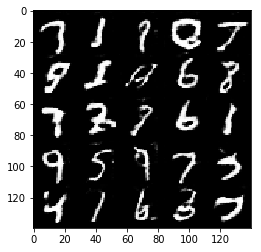

Epoch 1/2... Step 1710... Learning rate 0.0002507... Discriminator Loss: 0.6629... Generator Loss: 1.5949
Epoch 1/2... Step 1720... Learning rate 0.0002497... Discriminator Loss: 0.7351... Generator Loss: 1.4065
Epoch 1/2... Step 1730... Learning rate 0.0002488... Discriminator Loss: 0.6296... Generator Loss: 1.5304
Epoch 1/2... Step 1740... Learning rate 0.0002478... Discriminator Loss: 0.5229... Generator Loss: 2.1777
Epoch 1/2... Step 1750... Learning rate 0.0002469... Discriminator Loss: 0.6134... Generator Loss: 1.4494
Epoch 1/2... Step 1760... Learning rate 0.0002460... Discriminator Loss: 0.7700... Generator Loss: 1.4008
Epoch 1/2... Step 1770... Learning rate 0.0002451... Discriminator Loss: 0.6951... Generator Loss: 2.6118
Epoch 1/2... Step 1780... Learning rate 0.0002442... Discriminator Loss: 1.3996... Generator Loss: 0.6665
Epoch 1/2... Step 1790... Learning rate 0.0002434... Discriminator Loss: 0.8170... Generator Loss: 2.5968
Epoch 1/2... Step 1800... Learning rate 0.0002

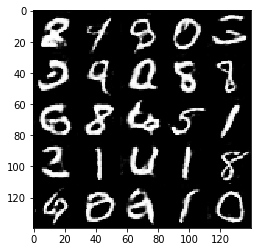

Epoch 1/2... Step 1810... Learning rate 0.0002417... Discriminator Loss: 0.5917... Generator Loss: 1.5181
Epoch 1/2... Step 1820... Learning rate 0.0002409... Discriminator Loss: 0.7006... Generator Loss: 2.0896
Epoch 1/2... Step 1830... Learning rate 0.0002401... Discriminator Loss: 0.7686... Generator Loss: 1.2244
Epoch 1/2... Step 1840... Learning rate 0.0002394... Discriminator Loss: 1.0031... Generator Loss: 1.2129
Epoch 1/2... Step 1850... Learning rate 0.0002386... Discriminator Loss: 0.7201... Generator Loss: 1.1602
Epoch 1/2... Step 1860... Learning rate 0.0002379... Discriminator Loss: 0.5845... Generator Loss: 1.8301
Epoch 1/2... Step 1870... Learning rate 0.0002371... Discriminator Loss: 0.5868... Generator Loss: 2.1469
Epoch 2/2... Step 1880... Learning rate 0.0002364... Discriminator Loss: 0.8841... Generator Loss: 1.0376
Epoch 2/2... Step 1890... Learning rate 0.0002357... Discriminator Loss: 0.5138... Generator Loss: 1.9965
Epoch 2/2... Step 1900... Learning rate 0.0002

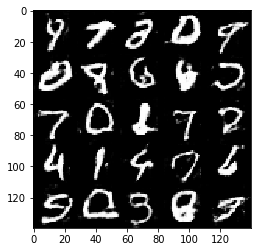

Epoch 2/2... Step 1910... Learning rate 0.0002343... Discriminator Loss: 1.1070... Generator Loss: 0.6386
Epoch 2/2... Step 1920... Learning rate 0.0002337... Discriminator Loss: 0.5985... Generator Loss: 2.4563
Epoch 2/2... Step 1930... Learning rate 0.0002330... Discriminator Loss: 0.7840... Generator Loss: 1.3201
Epoch 2/2... Step 1940... Learning rate 0.0002324... Discriminator Loss: 0.5385... Generator Loss: 2.8699
Epoch 2/2... Step 1950... Learning rate 0.0002317... Discriminator Loss: 0.6528... Generator Loss: 1.6159
Epoch 2/2... Step 1960... Learning rate 0.0002311... Discriminator Loss: 0.4796... Generator Loss: 2.4196
Epoch 2/2... Step 1970... Learning rate 0.0002305... Discriminator Loss: 0.5197... Generator Loss: 2.2228
Epoch 2/2... Step 1980... Learning rate 0.0002299... Discriminator Loss: 0.4301... Generator Loss: 3.0777
Epoch 2/2... Step 1990... Learning rate 0.0002293... Discriminator Loss: 0.5589... Generator Loss: 2.3621
Epoch 2/2... Step 2000... Learning rate 0.0002

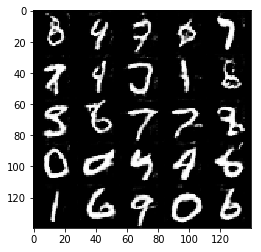

Epoch 2/2... Step 2010... Learning rate 0.0002282... Discriminator Loss: 1.4039... Generator Loss: 3.6851
Epoch 2/2... Step 2020... Learning rate 0.0002277... Discriminator Loss: 0.7430... Generator Loss: 1.5129
Epoch 2/2... Step 2030... Learning rate 0.0002271... Discriminator Loss: 0.9630... Generator Loss: 1.1890
Epoch 2/2... Step 2040... Learning rate 0.0002266... Discriminator Loss: 0.7398... Generator Loss: 1.2651
Epoch 2/2... Step 2050... Learning rate 0.0002261... Discriminator Loss: 0.6069... Generator Loss: 2.0288
Epoch 2/2... Step 2060... Learning rate 0.0002256... Discriminator Loss: 0.6188... Generator Loss: 2.0497
Epoch 2/2... Step 2070... Learning rate 0.0002251... Discriminator Loss: 0.5635... Generator Loss: 1.7886
Epoch 2/2... Step 2080... Learning rate 0.0002246... Discriminator Loss: 0.6054... Generator Loss: 1.6009
Epoch 2/2... Step 2090... Learning rate 0.0002241... Discriminator Loss: 0.6130... Generator Loss: 1.9636
Epoch 2/2... Step 2100... Learning rate 0.0002

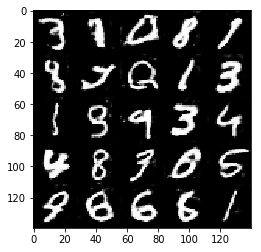

Epoch 2/2... Step 2110... Learning rate 0.0002232... Discriminator Loss: 0.7950... Generator Loss: 1.1944
Epoch 2/2... Step 2120... Learning rate 0.0002227... Discriminator Loss: 0.6603... Generator Loss: 2.0782
Epoch 2/2... Step 2130... Learning rate 0.0002223... Discriminator Loss: 0.7113... Generator Loss: 1.5998
Epoch 2/2... Step 2140... Learning rate 0.0002218... Discriminator Loss: 0.5166... Generator Loss: 1.7957
Epoch 2/2... Step 2150... Learning rate 0.0002214... Discriminator Loss: 0.6245... Generator Loss: 2.6052
Epoch 2/2... Step 2160... Learning rate 0.0002210... Discriminator Loss: 1.0455... Generator Loss: 0.8186
Epoch 2/2... Step 2170... Learning rate 0.0002206... Discriminator Loss: 0.7838... Generator Loss: 1.2554
Epoch 2/2... Step 2180... Learning rate 0.0002202... Discriminator Loss: 0.4719... Generator Loss: 2.8235
Epoch 2/2... Step 2190... Learning rate 0.0002198... Discriminator Loss: 0.6114... Generator Loss: 1.5364
Epoch 2/2... Step 2200... Learning rate 0.0002

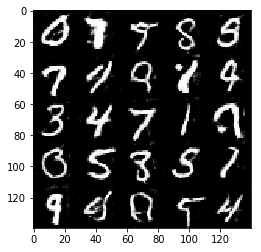

Epoch 2/2... Step 2210... Learning rate 0.0002190... Discriminator Loss: 0.4566... Generator Loss: 2.7353
Epoch 2/2... Step 2220... Learning rate 0.0002187... Discriminator Loss: 0.7147... Generator Loss: 1.8473
Epoch 2/2... Step 2230... Learning rate 0.0002183... Discriminator Loss: 0.4548... Generator Loss: 2.7845
Epoch 2/2... Step 2240... Learning rate 0.0002179... Discriminator Loss: 0.8598... Generator Loss: 1.1716
Epoch 2/2... Step 2250... Learning rate 0.0002176... Discriminator Loss: 0.5800... Generator Loss: 2.0591
Epoch 2/2... Step 2260... Learning rate 0.0002172... Discriminator Loss: 0.7454... Generator Loss: 1.4066
Epoch 2/2... Step 2270... Learning rate 0.0002169... Discriminator Loss: 0.5762... Generator Loss: 2.2332
Epoch 2/2... Step 2280... Learning rate 0.0002166... Discriminator Loss: 0.7130... Generator Loss: 1.3776
Epoch 2/2... Step 2290... Learning rate 0.0002162... Discriminator Loss: 0.6008... Generator Loss: 1.7890
Epoch 2/2... Step 2300... Learning rate 0.0002

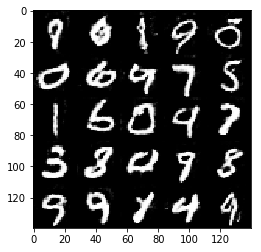

Epoch 2/2... Step 2310... Learning rate 0.0002156... Discriminator Loss: 0.7224... Generator Loss: 1.7996
Epoch 2/2... Step 2320... Learning rate 0.0002153... Discriminator Loss: 0.7120... Generator Loss: 1.5443
Epoch 2/2... Step 2330... Learning rate 0.0002150... Discriminator Loss: 0.8474... Generator Loss: 1.5739
Epoch 2/2... Step 2340... Learning rate 0.0002147... Discriminator Loss: 0.6739... Generator Loss: 1.4561
Epoch 2/2... Step 2350... Learning rate 0.0002144... Discriminator Loss: 0.8853... Generator Loss: 1.0879
Epoch 2/2... Step 2360... Learning rate 0.0002141... Discriminator Loss: 0.5484... Generator Loss: 1.9556
Epoch 2/2... Step 2370... Learning rate 0.0002139... Discriminator Loss: 0.6329... Generator Loss: 1.2451
Epoch 2/2... Step 2380... Learning rate 0.0002136... Discriminator Loss: 0.5633... Generator Loss: 2.0365
Epoch 2/2... Step 2390... Learning rate 0.0002133... Discriminator Loss: 0.4544... Generator Loss: 2.3025
Epoch 2/2... Step 2400... Learning rate 0.0002

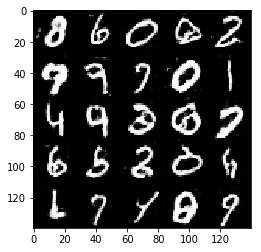

Epoch 2/2... Step 2410... Learning rate 0.0002128... Discriminator Loss: 0.9314... Generator Loss: 0.9989
Epoch 2/2... Step 2420... Learning rate 0.0002126... Discriminator Loss: 0.6456... Generator Loss: 1.6362
Epoch 2/2... Step 2430... Learning rate 0.0002123... Discriminator Loss: 0.4827... Generator Loss: 2.9826
Epoch 2/2... Step 2440... Learning rate 0.0002121... Discriminator Loss: 0.5446... Generator Loss: 1.8585
Epoch 2/2... Step 2450... Learning rate 0.0002118... Discriminator Loss: 0.4645... Generator Loss: 2.0719
Epoch 2/2... Step 2460... Learning rate 0.0002116... Discriminator Loss: 0.6828... Generator Loss: 1.4707
Epoch 2/2... Step 2470... Learning rate 0.0002114... Discriminator Loss: 0.6812... Generator Loss: 1.8740
Epoch 2/2... Step 2480... Learning rate 0.0002111... Discriminator Loss: 1.0960... Generator Loss: 0.7656
Epoch 2/2... Step 2490... Learning rate 0.0002109... Discriminator Loss: 0.4681... Generator Loss: 2.2707
Epoch 2/2... Step 2500... Learning rate 0.0002

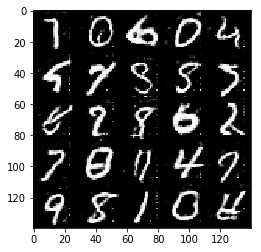

Epoch 2/2... Step 2510... Learning rate 0.0002105... Discriminator Loss: 0.4878... Generator Loss: 2.4863
Epoch 2/2... Step 2520... Learning rate 0.0002103... Discriminator Loss: 0.4786... Generator Loss: 2.6577
Epoch 2/2... Step 2530... Learning rate 0.0002101... Discriminator Loss: 0.6503... Generator Loss: 1.6401
Epoch 2/2... Step 2540... Learning rate 0.0002099... Discriminator Loss: 0.7557... Generator Loss: 1.6852
Epoch 2/2... Step 2550... Learning rate 0.0002097... Discriminator Loss: 0.8467... Generator Loss: 1.3019
Epoch 2/2... Step 2560... Learning rate 0.0002095... Discriminator Loss: 0.5719... Generator Loss: 1.9650
Epoch 2/2... Step 2570... Learning rate 0.0002093... Discriminator Loss: 0.5389... Generator Loss: 2.6950
Epoch 2/2... Step 2580... Learning rate 0.0002091... Discriminator Loss: 0.8011... Generator Loss: 0.9602
Epoch 2/2... Step 2590... Learning rate 0.0002090... Discriminator Loss: 0.5591... Generator Loss: 2.7704
Epoch 2/2... Step 2600... Learning rate 0.0002

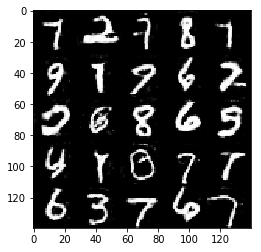

Epoch 2/2... Step 2610... Learning rate 0.0002086... Discriminator Loss: 0.4740... Generator Loss: 2.4921
Epoch 2/2... Step 2620... Learning rate 0.0002084... Discriminator Loss: 0.5496... Generator Loss: 2.7516
Epoch 2/2... Step 2630... Learning rate 0.0002083... Discriminator Loss: 0.4416... Generator Loss: 2.7844
Epoch 2/2... Step 2640... Learning rate 0.0002081... Discriminator Loss: 0.4197... Generator Loss: 3.7042
Epoch 2/2... Step 2650... Learning rate 0.0002079... Discriminator Loss: 0.6056... Generator Loss: 1.7783
Epoch 2/2... Step 2660... Learning rate 0.0002078... Discriminator Loss: 0.4366... Generator Loss: 3.0931
Epoch 2/2... Step 2670... Learning rate 0.0002076... Discriminator Loss: 0.4456... Generator Loss: 2.8965
Epoch 2/2... Step 2680... Learning rate 0.0002075... Discriminator Loss: 0.4719... Generator Loss: 2.9037
Epoch 2/2... Step 2690... Learning rate 0.0002073... Discriminator Loss: 0.5447... Generator Loss: 2.2283
Epoch 2/2... Step 2700... Learning rate 0.0002

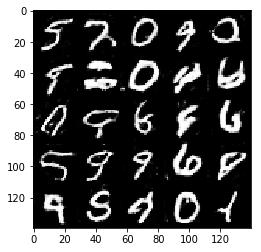

Epoch 2/2... Step 2710... Learning rate 0.0002071... Discriminator Loss: 0.6998... Generator Loss: 1.6218
Epoch 2/2... Step 2720... Learning rate 0.0002069... Discriminator Loss: 0.4666... Generator Loss: 2.6142
Epoch 2/2... Step 2730... Learning rate 0.0002068... Discriminator Loss: 0.5986... Generator Loss: 2.3278
Epoch 2/2... Step 2740... Learning rate 0.0002066... Discriminator Loss: 0.6992... Generator Loss: 1.9588
Epoch 2/2... Step 2750... Learning rate 0.0002065... Discriminator Loss: 0.4968... Generator Loss: 2.0758
Epoch 2/2... Step 2760... Learning rate 0.0002064... Discriminator Loss: 0.5813... Generator Loss: 2.2055
Epoch 2/2... Step 2770... Learning rate 0.0002063... Discriminator Loss: 0.4503... Generator Loss: 2.4336
Epoch 2/2... Step 2780... Learning rate 0.0002061... Discriminator Loss: 0.7468... Generator Loss: 1.4804
Epoch 2/2... Step 2790... Learning rate 0.0002060... Discriminator Loss: 0.5867... Generator Loss: 1.6919
Epoch 2/2... Step 2800... Learning rate 0.0002

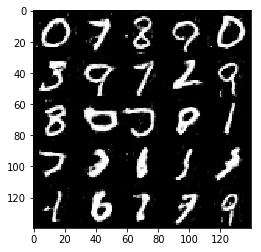

Epoch 2/2... Step 2810... Learning rate 0.0002058... Discriminator Loss: 0.4601... Generator Loss: 2.7297
Epoch 2/2... Step 2820... Learning rate 0.0002057... Discriminator Loss: 0.8906... Generator Loss: 1.2763
Epoch 2/2... Step 2830... Learning rate 0.0002056... Discriminator Loss: 0.4668... Generator Loss: 3.2514
Epoch 2/2... Step 2840... Learning rate 0.0002054... Discriminator Loss: 0.5981... Generator Loss: 2.0857
Epoch 2/2... Step 2850... Learning rate 0.0002053... Discriminator Loss: 0.4732... Generator Loss: 2.4056
Epoch 2/2... Step 2860... Learning rate 0.0002052... Discriminator Loss: 0.6340... Generator Loss: 1.7865
Epoch 2/2... Step 2870... Learning rate 0.0002051... Discriminator Loss: 0.9092... Generator Loss: 1.0165
Epoch 2/2... Step 2880... Learning rate 0.0002050... Discriminator Loss: 0.8605... Generator Loss: 0.7499
Epoch 2/2... Step 2890... Learning rate 0.0002049... Discriminator Loss: 0.7363... Generator Loss: 2.5464
Epoch 2/2... Step 2900... Learning rate 0.0002

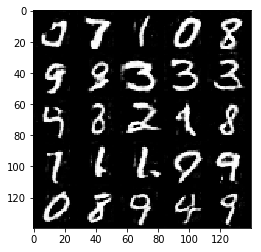

Epoch 2/2... Step 2910... Learning rate 0.0002047... Discriminator Loss: 0.6242... Generator Loss: 1.6167
Epoch 2/2... Step 2920... Learning rate 0.0002046... Discriminator Loss: 0.4797... Generator Loss: 2.8862
Epoch 2/2... Step 2930... Learning rate 0.0002045... Discriminator Loss: 0.5079... Generator Loss: 2.6264
Epoch 2/2... Step 2940... Learning rate 0.0002045... Discriminator Loss: 0.4722... Generator Loss: 2.2791
Epoch 2/2... Step 2950... Learning rate 0.0002044... Discriminator Loss: 0.4818... Generator Loss: 2.2811
Epoch 2/2... Step 2960... Learning rate 0.0002043... Discriminator Loss: 0.4987... Generator Loss: 2.6578
Epoch 2/2... Step 2970... Learning rate 0.0002042... Discriminator Loss: 0.4359... Generator Loss: 3.3022
Epoch 2/2... Step 2980... Learning rate 0.0002041... Discriminator Loss: 0.7647... Generator Loss: 1.7806
Epoch 2/2... Step 2990... Learning rate 0.0002040... Discriminator Loss: 0.4675... Generator Loss: 2.1672
Epoch 2/2... Step 3000... Learning rate 0.0002

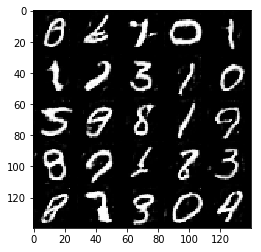

Epoch 2/2... Step 3010... Learning rate 0.0002039... Discriminator Loss: 0.6273... Generator Loss: 1.8107
Epoch 2/2... Step 3020... Learning rate 0.0002038... Discriminator Loss: 0.6858... Generator Loss: 1.7203
Epoch 2/2... Step 3030... Learning rate 0.0002037... Discriminator Loss: 0.4980... Generator Loss: 1.9422
Epoch 2/2... Step 3040... Learning rate 0.0002037... Discriminator Loss: 0.5373... Generator Loss: 2.2715
Epoch 2/2... Step 3050... Learning rate 0.0002036... Discriminator Loss: 0.4650... Generator Loss: 1.8102
Epoch 2/2... Step 3060... Learning rate 0.0002035... Discriminator Loss: 0.5238... Generator Loss: 2.2304
Epoch 2/2... Step 3070... Learning rate 0.0002034... Discriminator Loss: 0.6472... Generator Loss: 1.8464
Epoch 2/2... Step 3080... Learning rate 0.0002034... Discriminator Loss: 0.4665... Generator Loss: 2.2788
Epoch 2/2... Step 3090... Learning rate 0.0002033... Discriminator Loss: 0.4651... Generator Loss: 2.7297
Epoch 2/2... Step 3100... Learning rate 0.0002

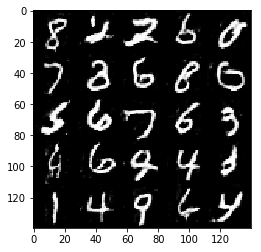

Epoch 2/2... Step 3110... Learning rate 0.0002032... Discriminator Loss: 1.1892... Generator Loss: 0.7206
Epoch 2/2... Step 3120... Learning rate 0.0002031... Discriminator Loss: 0.4909... Generator Loss: 2.4727
Epoch 2/2... Step 3130... Learning rate 0.0002031... Discriminator Loss: 0.4883... Generator Loss: 2.0902
Epoch 2/2... Step 3140... Learning rate 0.0002030... Discriminator Loss: 0.7654... Generator Loss: 1.3378
Epoch 2/2... Step 3150... Learning rate 0.0002029... Discriminator Loss: 0.5108... Generator Loss: 2.1086
Epoch 2/2... Step 3160... Learning rate 0.0002029... Discriminator Loss: 0.4560... Generator Loss: 2.6129
Epoch 2/2... Step 3170... Learning rate 0.0002028... Discriminator Loss: 0.6409... Generator Loss: 1.5593
Epoch 2/2... Step 3180... Learning rate 0.0002028... Discriminator Loss: 0.5901... Generator Loss: 2.3824
Epoch 2/2... Step 3190... Learning rate 0.0002027... Discriminator Loss: 0.5996... Generator Loss: 1.4810
Epoch 2/2... Step 3200... Learning rate 0.0002

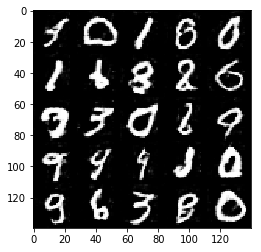

Epoch 2/2... Step 3210... Learning rate 0.0002026... Discriminator Loss: 0.5070... Generator Loss: 2.4217
Epoch 2/2... Step 3220... Learning rate 0.0002026... Discriminator Loss: 0.5491... Generator Loss: 2.2193
Epoch 2/2... Step 3230... Learning rate 0.0002025... Discriminator Loss: 0.4729... Generator Loss: 2.3023
Epoch 2/2... Step 3240... Learning rate 0.0002025... Discriminator Loss: 0.7226... Generator Loss: 1.7460
Epoch 2/2... Step 3250... Learning rate 0.0002024... Discriminator Loss: 0.6699... Generator Loss: 1.6065
Epoch 2/2... Step 3260... Learning rate 0.0002024... Discriminator Loss: 0.4686... Generator Loss: 2.2490
Epoch 2/2... Step 3270... Learning rate 0.0002023... Discriminator Loss: 0.7509... Generator Loss: 2.0794
Epoch 2/2... Step 3280... Learning rate 0.0002023... Discriminator Loss: 0.9994... Generator Loss: 0.9615
Epoch 2/2... Step 3290... Learning rate 0.0002022... Discriminator Loss: 0.7291... Generator Loss: 1.7687
Epoch 2/2... Step 3300... Learning rate 0.0002

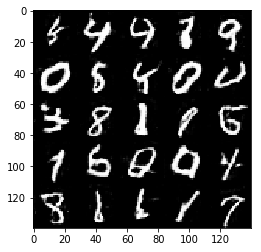

Epoch 2/2... Step 3310... Learning rate 0.0002021... Discriminator Loss: 0.6519... Generator Loss: 1.6022
Epoch 2/2... Step 3320... Learning rate 0.0002021... Discriminator Loss: 0.4483... Generator Loss: 2.2333
Epoch 2/2... Step 3330... Learning rate 0.0002020... Discriminator Loss: 0.4744... Generator Loss: 2.2337
Epoch 2/2... Step 3340... Learning rate 0.0002020... Discriminator Loss: 0.5728... Generator Loss: 2.0231
Epoch 2/2... Step 3350... Learning rate 0.0002020... Discriminator Loss: 0.4087... Generator Loss: 3.0231
Epoch 2/2... Step 3360... Learning rate 0.0002019... Discriminator Loss: 0.5085... Generator Loss: 2.7790
Epoch 2/2... Step 3370... Learning rate 0.0002019... Discriminator Loss: 0.6483... Generator Loss: 1.8691
Epoch 2/2... Step 3380... Learning rate 0.0002019... Discriminator Loss: 0.5279... Generator Loss: 1.9537
Epoch 2/2... Step 3390... Learning rate 0.0002018... Discriminator Loss: 0.5288... Generator Loss: 2.4277
Epoch 2/2... Step 3400... Learning rate 0.0002

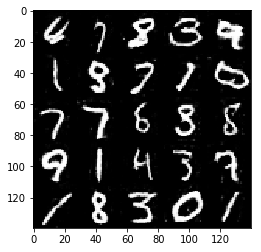

Epoch 2/2... Step 3410... Learning rate 0.0002017... Discriminator Loss: 0.5740... Generator Loss: 1.8120
Epoch 2/2... Step 3420... Learning rate 0.0002017... Discriminator Loss: 0.6123... Generator Loss: 1.5317
Epoch 2/2... Step 3430... Learning rate 0.0002017... Discriminator Loss: 0.4716... Generator Loss: 2.3783
Epoch 2/2... Step 3440... Learning rate 0.0002016... Discriminator Loss: 0.5493... Generator Loss: 2.1985
Epoch 2/2... Step 3450... Learning rate 0.0002016... Discriminator Loss: 0.5000... Generator Loss: 2.6376
Epoch 2/2... Step 3460... Learning rate 0.0002016... Discriminator Loss: 0.6920... Generator Loss: 1.8100
Epoch 2/2... Step 3470... Learning rate 0.0002015... Discriminator Loss: 0.5090... Generator Loss: 2.4723
Epoch 2/2... Step 3480... Learning rate 0.0002015... Discriminator Loss: 0.4858... Generator Loss: 3.1409
Epoch 2/2... Step 3490... Learning rate 0.0002015... Discriminator Loss: 0.6001... Generator Loss: 1.9890
Epoch 2/2... Step 3500... Learning rate 0.0002

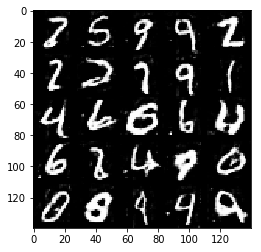

Epoch 2/2... Step 3510... Learning rate 0.0002014... Discriminator Loss: 0.9908... Generator Loss: 1.2758
Epoch 2/2... Step 3520... Learning rate 0.0002014... Discriminator Loss: 0.5206... Generator Loss: 2.0044
Epoch 2/2... Step 3530... Learning rate 0.0002014... Discriminator Loss: 0.4441... Generator Loss: 2.8551
Epoch 2/2... Step 3540... Learning rate 0.0002013... Discriminator Loss: 0.4666... Generator Loss: 2.2187
Epoch 2/2... Step 3550... Learning rate 0.0002013... Discriminator Loss: 0.5081... Generator Loss: 2.2921
Epoch 2/2... Step 3560... Learning rate 0.0002013... Discriminator Loss: 0.4871... Generator Loss: 1.8647
Epoch 2/2... Step 3570... Learning rate 0.0002013... Discriminator Loss: 0.5663... Generator Loss: 1.6960
Epoch 2/2... Step 3580... Learning rate 0.0002012... Discriminator Loss: 0.4550... Generator Loss: 2.5719
Epoch 2/2... Step 3590... Learning rate 0.0002012... Discriminator Loss: 0.5809... Generator Loss: 1.6485
Epoch 2/2... Step 3600... Learning rate 0.0002

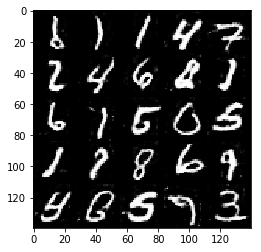

Epoch 2/2... Step 3610... Learning rate 0.0002012... Discriminator Loss: 0.6282... Generator Loss: 2.0676
Epoch 2/2... Step 3620... Learning rate 0.0002011... Discriminator Loss: 0.4998... Generator Loss: 2.4141
Epoch 2/2... Step 3630... Learning rate 0.0002011... Discriminator Loss: 0.5560... Generator Loss: 2.0970
Epoch 2/2... Step 3640... Learning rate 0.0002011... Discriminator Loss: 0.4811... Generator Loss: 2.4277
Epoch 2/2... Step 3650... Learning rate 0.0002011... Discriminator Loss: 0.5485... Generator Loss: 2.0042
Epoch 2/2... Step 3660... Learning rate 0.0002011... Discriminator Loss: 0.4497... Generator Loss: 2.2857
Epoch 2/2... Step 3670... Learning rate 0.0002010... Discriminator Loss: 0.7311... Generator Loss: 1.5575
Epoch 2/2... Step 3680... Learning rate 0.0002010... Discriminator Loss: 0.4898... Generator Loss: 2.3485
Epoch 2/2... Step 3690... Learning rate 0.0002010... Discriminator Loss: 0.4416... Generator Loss: 2.6664
Epoch 2/2... Step 3700... Learning rate 0.0002

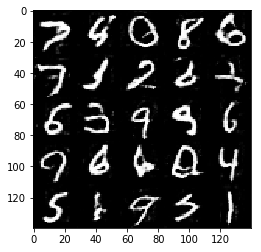

Epoch 2/2... Step 3710... Learning rate 0.0002010... Discriminator Loss: 0.4608... Generator Loss: 2.4392
Epoch 2/2... Step 3720... Learning rate 0.0002009... Discriminator Loss: 0.6989... Generator Loss: 1.8045
Epoch 2/2... Step 3730... Learning rate 0.0002009... Discriminator Loss: 0.3917... Generator Loss: 3.1193
Epoch 2/2... Step 3740... Learning rate 0.0002009... Discriminator Loss: 0.4809... Generator Loss: 2.4279
Epoch 2/2... Step 3750... Learning rate 0.0002009... Discriminator Loss: 0.6513... Generator Loss: 2.8120


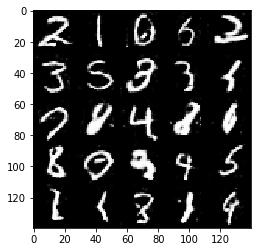

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10... Learning rate 0.0004960... Discriminator Loss: 2.6885... Generator Loss: 2.5573
Epoch 1/1... Step 20... Learning rate 0.0004920... Discriminator Loss: 1.5052... Generator Loss: 2.8812
Epoch 1/1... Step 30... Learning rate 0.0004880... Discriminator Loss: 2.7472... Generator Loss: 0.2385
Epoch 1/1... Step 40... Learning rate 0.0004840... Discriminator Loss: 0.8191... Generator Loss: 1.3999
Epoch 1/1... Step 50... Learning rate 0.0004800... Discriminator Loss: 1.6458... Generator Loss: 0.6618
Epoch 1/1... Step 60... Learning rate 0.0004760... Discriminator Loss: 1.2397... Generator Loss: 0.9625
Epoch 1/1... Step 70... Learning rate 0.0004720... Discriminator Loss: 1.1147... Generator Loss: 1.0509
Epoch 1/1... Step 80... Learning rate 0.0004681... Discriminator Loss: 1.7130... Generator Loss: 0.9258
Epoch 1/1... Step 90... Learning rate 0.0004641... Discriminator Loss: 1.7468... Generator Loss: 0.6778
Epoch 1/1... Step 100... Learning rate 0.0004601... Discriminato

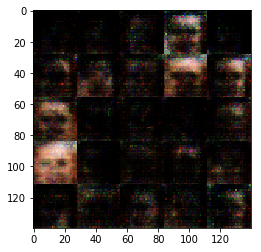

Epoch 1/1... Step 110... Learning rate 0.0004562... Discriminator Loss: 1.2710... Generator Loss: 1.1585
Epoch 1/1... Step 120... Learning rate 0.0004522... Discriminator Loss: 1.6235... Generator Loss: 1.6438
Epoch 1/1... Step 130... Learning rate 0.0004483... Discriminator Loss: 1.3301... Generator Loss: 0.6410
Epoch 1/1... Step 140... Learning rate 0.0004444... Discriminator Loss: 1.2658... Generator Loss: 0.9792
Epoch 1/1... Step 150... Learning rate 0.0004404... Discriminator Loss: 1.6288... Generator Loss: 0.4655
Epoch 1/1... Step 160... Learning rate 0.0004365... Discriminator Loss: 1.4613... Generator Loss: 0.7633
Epoch 1/1... Step 170... Learning rate 0.0004326... Discriminator Loss: 1.3390... Generator Loss: 0.8245
Epoch 1/1... Step 180... Learning rate 0.0004288... Discriminator Loss: 1.4614... Generator Loss: 0.7265
Epoch 1/1... Step 190... Learning rate 0.0004249... Discriminator Loss: 1.1762... Generator Loss: 0.7412
Epoch 1/1... Step 200... Learning rate 0.0004210... Dis

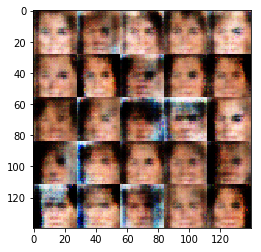

Epoch 1/1... Step 210... Learning rate 0.0004172... Discriminator Loss: 1.7987... Generator Loss: 0.5334
Epoch 1/1... Step 220... Learning rate 0.0004134... Discriminator Loss: 1.3928... Generator Loss: 0.6896
Epoch 1/1... Step 230... Learning rate 0.0004096... Discriminator Loss: 1.4211... Generator Loss: 0.8968
Epoch 1/1... Step 240... Learning rate 0.0004058... Discriminator Loss: 1.4439... Generator Loss: 0.5588
Epoch 1/1... Step 250... Learning rate 0.0004020... Discriminator Loss: 1.3987... Generator Loss: 1.0931
Epoch 1/1... Step 260... Learning rate 0.0003983... Discriminator Loss: 1.3702... Generator Loss: 0.7562
Epoch 1/1... Step 270... Learning rate 0.0003946... Discriminator Loss: 1.5506... Generator Loss: 0.7620
Epoch 1/1... Step 280... Learning rate 0.0003908... Discriminator Loss: 1.3869... Generator Loss: 0.7234
Epoch 1/1... Step 290... Learning rate 0.0003871... Discriminator Loss: 1.3235... Generator Loss: 0.5823
Epoch 1/1... Step 300... Learning rate 0.0003835... Dis

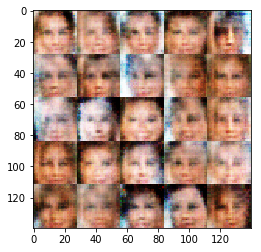

Epoch 1/1... Step 310... Learning rate 0.0003798... Discriminator Loss: 1.3305... Generator Loss: 0.6534
Epoch 1/1... Step 320... Learning rate 0.0003762... Discriminator Loss: 1.3578... Generator Loss: 1.1338
Epoch 1/1... Step 330... Learning rate 0.0003726... Discriminator Loss: 1.3524... Generator Loss: 0.7273
Epoch 1/1... Step 340... Learning rate 0.0003690... Discriminator Loss: 1.4190... Generator Loss: 0.7124
Epoch 1/1... Step 350... Learning rate 0.0003654... Discriminator Loss: 1.4749... Generator Loss: 0.8161
Epoch 1/1... Step 360... Learning rate 0.0003619... Discriminator Loss: 1.3355... Generator Loss: 0.7862
Epoch 1/1... Step 370... Learning rate 0.0003584... Discriminator Loss: 1.4971... Generator Loss: 0.9112
Epoch 1/1... Step 380... Learning rate 0.0003549... Discriminator Loss: 1.3271... Generator Loss: 0.8331
Epoch 1/1... Step 390... Learning rate 0.0003515... Discriminator Loss: 1.7556... Generator Loss: 0.3741
Epoch 1/1... Step 400... Learning rate 0.0003480... Dis

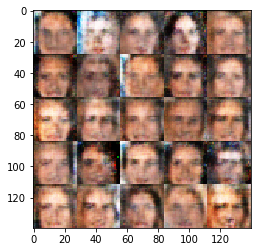

Epoch 1/1... Step 410... Learning rate 0.0003446... Discriminator Loss: 1.4274... Generator Loss: 0.7672
Epoch 1/1... Step 420... Learning rate 0.0003412... Discriminator Loss: 1.4433... Generator Loss: 0.5326
Epoch 1/1... Step 430... Learning rate 0.0003379... Discriminator Loss: 1.4931... Generator Loss: 0.7979
Epoch 1/1... Step 440... Learning rate 0.0003345... Discriminator Loss: 1.3864... Generator Loss: 0.9486
Epoch 1/1... Step 450... Learning rate 0.0003312... Discriminator Loss: 1.4710... Generator Loss: 0.7438
Epoch 1/1... Step 460... Learning rate 0.0003280... Discriminator Loss: 1.4159... Generator Loss: 0.8557
Epoch 1/1... Step 470... Learning rate 0.0003247... Discriminator Loss: 1.4409... Generator Loss: 0.9453
Epoch 1/1... Step 480... Learning rate 0.0003215... Discriminator Loss: 1.5628... Generator Loss: 0.7025
Epoch 1/1... Step 490... Learning rate 0.0003183... Discriminator Loss: 1.5210... Generator Loss: 0.7743
Epoch 1/1... Step 500... Learning rate 0.0003152... Dis

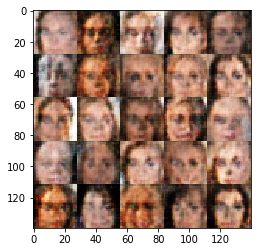

Epoch 1/1... Step 510... Learning rate 0.0003120... Discriminator Loss: 1.4247... Generator Loss: 0.7974
Epoch 1/1... Step 520... Learning rate 0.0003089... Discriminator Loss: 1.4341... Generator Loss: 0.7507
Epoch 1/1... Step 530... Learning rate 0.0003058... Discriminator Loss: 1.4753... Generator Loss: 0.6566
Epoch 1/1... Step 540... Learning rate 0.0003028... Discriminator Loss: 1.4647... Generator Loss: 0.7255
Epoch 1/1... Step 550... Learning rate 0.0002998... Discriminator Loss: 1.3503... Generator Loss: 0.7746
Epoch 1/1... Step 560... Learning rate 0.0002968... Discriminator Loss: 1.4500... Generator Loss: 0.8151
Epoch 1/1... Step 570... Learning rate 0.0002939... Discriminator Loss: 1.2933... Generator Loss: 0.7922
Epoch 1/1... Step 580... Learning rate 0.0002909... Discriminator Loss: 1.4312... Generator Loss: 0.7024
Epoch 1/1... Step 590... Learning rate 0.0002880... Discriminator Loss: 1.4580... Generator Loss: 0.7660
Epoch 1/1... Step 600... Learning rate 0.0002852... Dis

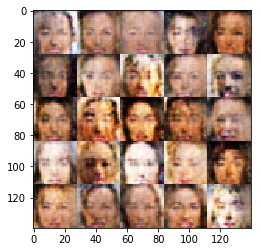

Epoch 1/1... Step 610... Learning rate 0.0002823... Discriminator Loss: 1.5443... Generator Loss: 0.6322
Epoch 1/1... Step 620... Learning rate 0.0002795... Discriminator Loss: 1.5388... Generator Loss: 0.6668
Epoch 1/1... Step 630... Learning rate 0.0002768... Discriminator Loss: 1.5469... Generator Loss: 0.5674
Epoch 1/1... Step 640... Learning rate 0.0002740... Discriminator Loss: 1.4899... Generator Loss: 0.6672
Epoch 1/1... Step 650... Learning rate 0.0002713... Discriminator Loss: 1.4792... Generator Loss: 0.7413
Epoch 1/1... Step 660... Learning rate 0.0002687... Discriminator Loss: 1.4292... Generator Loss: 0.7370
Epoch 1/1... Step 670... Learning rate 0.0002660... Discriminator Loss: 1.4650... Generator Loss: 0.6782
Epoch 1/1... Step 680... Learning rate 0.0002634... Discriminator Loss: 1.4091... Generator Loss: 0.7263
Epoch 1/1... Step 690... Learning rate 0.0002608... Discriminator Loss: 1.3477... Generator Loss: 0.8113
Epoch 1/1... Step 700... Learning rate 0.0002583... Dis

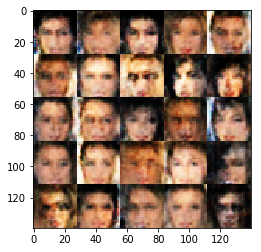

Epoch 1/1... Step 710... Learning rate 0.0002557... Discriminator Loss: 1.5038... Generator Loss: 0.7220
Epoch 1/1... Step 720... Learning rate 0.0002532... Discriminator Loss: 1.4385... Generator Loss: 0.8160
Epoch 1/1... Step 730... Learning rate 0.0002508... Discriminator Loss: 1.4263... Generator Loss: 0.9552
Epoch 1/1... Step 740... Learning rate 0.0002483... Discriminator Loss: 1.3181... Generator Loss: 0.8500
Epoch 1/1... Step 750... Learning rate 0.0002459... Discriminator Loss: 1.4648... Generator Loss: 0.6777
Epoch 1/1... Step 760... Learning rate 0.0002436... Discriminator Loss: 1.4189... Generator Loss: 0.8573
Epoch 1/1... Step 770... Learning rate 0.0002412... Discriminator Loss: 1.3173... Generator Loss: 0.8569
Epoch 1/1... Step 780... Learning rate 0.0002389... Discriminator Loss: 1.4541... Generator Loss: 0.6612
Epoch 1/1... Step 790... Learning rate 0.0002366... Discriminator Loss: 1.4413... Generator Loss: 0.6730
Epoch 1/1... Step 800... Learning rate 0.0002344... Dis

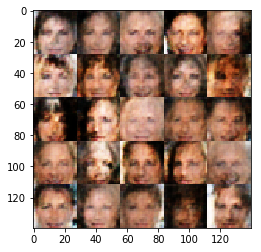

Epoch 1/1... Step 810... Learning rate 0.0002322... Discriminator Loss: 1.4407... Generator Loss: 0.7798
Epoch 1/1... Step 820... Learning rate 0.0002300... Discriminator Loss: 1.4139... Generator Loss: 0.7747
Epoch 1/1... Step 830... Learning rate 0.0002278... Discriminator Loss: 1.4848... Generator Loss: 0.7601
Epoch 1/1... Step 840... Learning rate 0.0002257... Discriminator Loss: 1.3614... Generator Loss: 0.7700
Epoch 1/1... Step 850... Learning rate 0.0002236... Discriminator Loss: 1.3645... Generator Loss: 0.7356
Epoch 1/1... Step 860... Learning rate 0.0002215... Discriminator Loss: 1.4058... Generator Loss: 0.8224
Epoch 1/1... Step 870... Learning rate 0.0002195... Discriminator Loss: 1.3025... Generator Loss: 0.7969
Epoch 1/1... Step 880... Learning rate 0.0002174... Discriminator Loss: 1.4788... Generator Loss: 0.7708
Epoch 1/1... Step 890... Learning rate 0.0002154... Discriminator Loss: 1.4141... Generator Loss: 0.6366
Epoch 1/1... Step 900... Learning rate 0.0002135... Dis

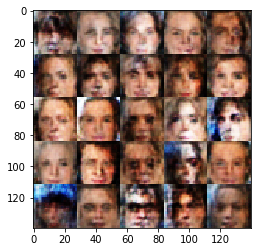

Epoch 1/1... Step 910... Learning rate 0.0002115... Discriminator Loss: 1.4390... Generator Loss: 0.6467
Epoch 1/1... Step 920... Learning rate 0.0002096... Discriminator Loss: 1.3882... Generator Loss: 0.7618
Epoch 1/1... Step 930... Learning rate 0.0002078... Discriminator Loss: 1.4184... Generator Loss: 0.6203
Epoch 1/1... Step 940... Learning rate 0.0002059... Discriminator Loss: 1.3866... Generator Loss: 0.7538
Epoch 1/1... Step 950... Learning rate 0.0002041... Discriminator Loss: 1.4024... Generator Loss: 0.5930
Epoch 1/1... Step 960... Learning rate 0.0002023... Discriminator Loss: 1.3676... Generator Loss: 0.6772
Epoch 1/1... Step 970... Learning rate 0.0002005... Discriminator Loss: 1.4092... Generator Loss: 0.7872
Epoch 1/1... Step 980... Learning rate 0.0001988... Discriminator Loss: 1.4519... Generator Loss: 0.7004
Epoch 1/1... Step 990... Learning rate 0.0001971... Discriminator Loss: 1.4134... Generator Loss: 0.7383
Epoch 1/1... Step 1000... Learning rate 0.0001954... Di

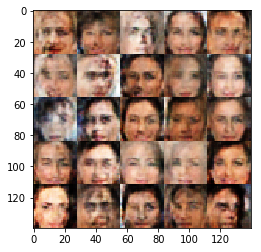

Epoch 1/1... Step 1010... Learning rate 0.0001937... Discriminator Loss: 1.4302... Generator Loss: 0.5602
Epoch 1/1... Step 1020... Learning rate 0.0001921... Discriminator Loss: 1.4601... Generator Loss: 0.6939
Epoch 1/1... Step 1030... Learning rate 0.0001904... Discriminator Loss: 1.4052... Generator Loss: 0.6772
Epoch 1/1... Step 1040... Learning rate 0.0001888... Discriminator Loss: 1.4199... Generator Loss: 0.6459
Epoch 1/1... Step 1050... Learning rate 0.0001873... Discriminator Loss: 1.3769... Generator Loss: 0.8548
Epoch 1/1... Step 1060... Learning rate 0.0001857... Discriminator Loss: 1.3510... Generator Loss: 0.8346
Epoch 1/1... Step 1070... Learning rate 0.0001842... Discriminator Loss: 1.3849... Generator Loss: 0.6667
Epoch 1/1... Step 1080... Learning rate 0.0001827... Discriminator Loss: 1.4388... Generator Loss: 0.6663
Epoch 1/1... Step 1090... Learning rate 0.0001812... Discriminator Loss: 1.3729... Generator Loss: 0.7305
Epoch 1/1... Step 1100... Learning rate 0.0001

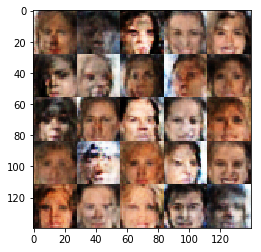

Epoch 1/1... Step 1110... Learning rate 0.0001784... Discriminator Loss: 1.3657... Generator Loss: 0.8561
Epoch 1/1... Step 1120... Learning rate 0.0001770... Discriminator Loss: 1.3908... Generator Loss: 0.8357
Epoch 1/1... Step 1130... Learning rate 0.0001756... Discriminator Loss: 1.4453... Generator Loss: 0.8803
Epoch 1/1... Step 1140... Learning rate 0.0001742... Discriminator Loss: 1.3724... Generator Loss: 0.7959
Epoch 1/1... Step 1150... Learning rate 0.0001729... Discriminator Loss: 1.4012... Generator Loss: 0.9133
Epoch 1/1... Step 1160... Learning rate 0.0001716... Discriminator Loss: 1.3887... Generator Loss: 0.7508
Epoch 1/1... Step 1170... Learning rate 0.0001703... Discriminator Loss: 1.3697... Generator Loss: 0.7715
Epoch 1/1... Step 1180... Learning rate 0.0001690... Discriminator Loss: 1.4257... Generator Loss: 0.7023
Epoch 1/1... Step 1190... Learning rate 0.0001678... Discriminator Loss: 1.4311... Generator Loss: 0.7781
Epoch 1/1... Step 1200... Learning rate 0.0001

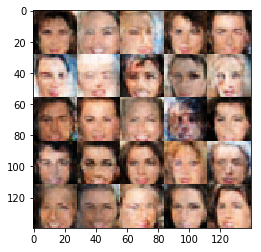

Epoch 1/1... Step 1210... Learning rate 0.0001653... Discriminator Loss: 1.3922... Generator Loss: 0.7877
Epoch 1/1... Step 1220... Learning rate 0.0001641... Discriminator Loss: 1.3775... Generator Loss: 0.7933
Epoch 1/1... Step 1230... Learning rate 0.0001630... Discriminator Loss: 1.4046... Generator Loss: 0.8594
Epoch 1/1... Step 1240... Learning rate 0.0001618... Discriminator Loss: 1.3891... Generator Loss: 0.7252
Epoch 1/1... Step 1250... Learning rate 0.0001607... Discriminator Loss: 1.4682... Generator Loss: 0.7686
Epoch 1/1... Step 1260... Learning rate 0.0001596... Discriminator Loss: 1.3652... Generator Loss: 0.8056
Epoch 1/1... Step 1270... Learning rate 0.0001585... Discriminator Loss: 1.4011... Generator Loss: 0.7899
Epoch 1/1... Step 1280... Learning rate 0.0001574... Discriminator Loss: 1.3672... Generator Loss: 0.8885
Epoch 1/1... Step 1290... Learning rate 0.0001563... Discriminator Loss: 1.3473... Generator Loss: 0.8384
Epoch 1/1... Step 1300... Learning rate 0.0001

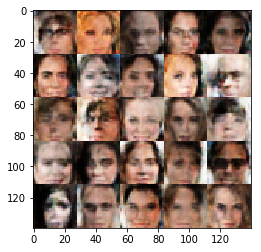

Epoch 1/1... Step 1310... Learning rate 0.0001543... Discriminator Loss: 1.3295... Generator Loss: 0.9248
Epoch 1/1... Step 1320... Learning rate 0.0001533... Discriminator Loss: 1.3839... Generator Loss: 0.7561
Epoch 1/1... Step 1330... Learning rate 0.0001523... Discriminator Loss: 1.3971... Generator Loss: 0.8229
Epoch 1/1... Step 1340... Learning rate 0.0001513... Discriminator Loss: 1.4305... Generator Loss: 0.7981
Epoch 1/1... Step 1350... Learning rate 0.0001504... Discriminator Loss: 1.3972... Generator Loss: 0.8106
Epoch 1/1... Step 1360... Learning rate 0.0001494... Discriminator Loss: 1.4417... Generator Loss: 0.6819
Epoch 1/1... Step 1370... Learning rate 0.0001485... Discriminator Loss: 1.4200... Generator Loss: 0.7891
Epoch 1/1... Step 1380... Learning rate 0.0001476... Discriminator Loss: 1.4337... Generator Loss: 0.7650
Epoch 1/1... Step 1390... Learning rate 0.0001467... Discriminator Loss: 1.4387... Generator Loss: 0.6508
Epoch 1/1... Step 1400... Learning rate 0.0001

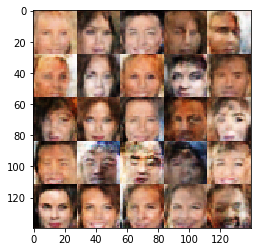

Epoch 1/1... Step 1410... Learning rate 0.0001450... Discriminator Loss: 1.3998... Generator Loss: 0.7725
Epoch 1/1... Step 1420... Learning rate 0.0001442... Discriminator Loss: 1.3999... Generator Loss: 0.7858
Epoch 1/1... Step 1430... Learning rate 0.0001433... Discriminator Loss: 1.4118... Generator Loss: 0.8127
Epoch 1/1... Step 1440... Learning rate 0.0001425... Discriminator Loss: 1.3897... Generator Loss: 0.7389
Epoch 1/1... Step 1450... Learning rate 0.0001417... Discriminator Loss: 1.3436... Generator Loss: 0.8169
Epoch 1/1... Step 1460... Learning rate 0.0001409... Discriminator Loss: 1.3917... Generator Loss: 0.7551
Epoch 1/1... Step 1470... Learning rate 0.0001402... Discriminator Loss: 1.3852... Generator Loss: 0.7808
Epoch 1/1... Step 1480... Learning rate 0.0001394... Discriminator Loss: 1.3722... Generator Loss: 0.7727
Epoch 1/1... Step 1490... Learning rate 0.0001387... Discriminator Loss: 1.3677... Generator Loss: 0.8174
Epoch 1/1... Step 1500... Learning rate 0.0001

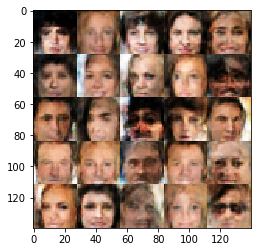

Epoch 1/1... Step 1510... Learning rate 0.0001372... Discriminator Loss: 1.4164... Generator Loss: 0.7607
Epoch 1/1... Step 1520... Learning rate 0.0001365... Discriminator Loss: 1.4421... Generator Loss: 0.7600
Epoch 1/1... Step 1530... Learning rate 0.0001358... Discriminator Loss: 1.3415... Generator Loss: 0.7665
Epoch 1/1... Step 1540... Learning rate 0.0001352... Discriminator Loss: 1.4276... Generator Loss: 0.7097
Epoch 1/1... Step 1550... Learning rate 0.0001345... Discriminator Loss: 1.4406... Generator Loss: 0.6737
Epoch 1/1... Step 1560... Learning rate 0.0001338... Discriminator Loss: 1.4392... Generator Loss: 0.7085
Epoch 1/1... Step 1570... Learning rate 0.0001332... Discriminator Loss: 1.4144... Generator Loss: 0.7431
Epoch 1/1... Step 1580... Learning rate 0.0001326... Discriminator Loss: 1.4601... Generator Loss: 0.7083


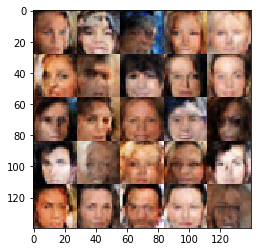

In [13]:
batch_size = 128
z_dim = 256
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.